# Spectropolarimetry Data Reduction of Elias 29 and Model Fitting 
Why? ---> Young Star 
Why? ---> Magnetic Field
Why? ---> Polarization Components

The aim of the code is to derive the polarization vs wavelength profile of the young star Elias 29 and analyze the origin of detected polarization by fitting a model.  
Major steps:
1. Obtain the Stokes parameters u, q, and I from telesope observation data.
2. Compute the polarization percentage, p=sqrt(u^2,q^2)/I
3. Bayesian approach modeling fitting to find out the major component of polarization, p(u,q)=p_abs(u,q)+p_em(u,q). 
    

In [476]:
import os
from pylab import *
import pymc3 as pm
from pymc3.stats import *
import numpy as np
import matplotlib.pyplot as plt
from readcol import readcol
from pandas import *
import aplpy
from astropy.io import fits
from readimage import readimage
###########plot#########################
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 14.
mpl.rcParams['xtick.labelsize'] = 11.
mpl.rcParams['ytick.labelsize'] = 11.

### Data Reduction to get U, Q, I

INFO: Auto-setting vmin to -2.058e+05 [aplpy.core]
INFO: Auto-setting vmax to  1.819e+05 [aplpy.core]


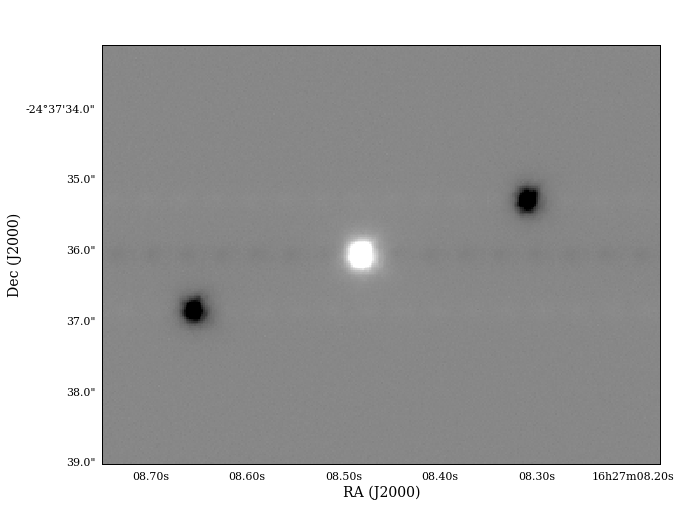

In [477]:
path='/Users/hanzhang/Documents/GitHub/insight_interw/'
im_file='ob0021/object/image.fits'
fitsfile = fits.open(path+im_file); image = fitsfile[0]
F = aplpy.FITSFigure(image)
F.show_grayscale()
plt.show()

This is the data of CAL_Elias29 at 2015-07-05 with filter Open Position Angle 72.0
for each waveplate, the number of frames 16


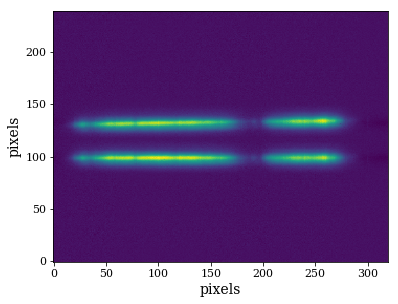

In [478]:
spec_file='ob0021/object/SpectroPolarim.fits'
spec,ip=readimage(path+spec_file)
plt.imshow(spec[0],origin='lower')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.show()

In [558]:
from cc_spec import *

Q, U, I, err_Q, err_U, err_I=cc_spec(spec,16,0.06,ip)

In [480]:
#########wavelength_calibration##########################
x=[196,40,284,80.5,158];y=[9.4941,12.5509,7.8813,11.7303,10.2622]
res_fit = np.polyfit(x, y, 2)
wave=np.polyval(res_fit,range(0,320))
wavet=rebin(wave[20:280],130)

### U/I, Q/I Plots

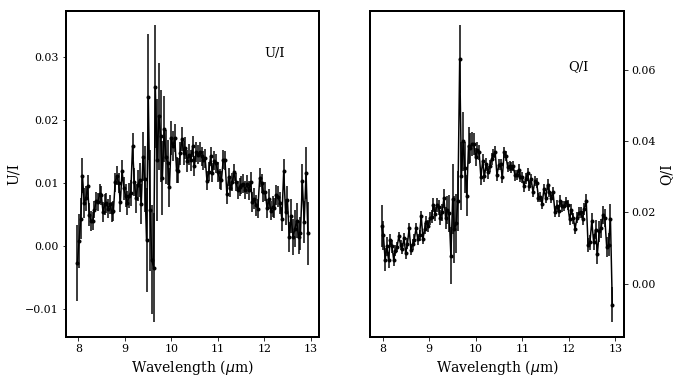

In [510]:
from plot_pol import *
plt.figure()
fig_size=plt.rcParams['figure.figsize']
fig_size[0]=10
fig_size[1]=6
ax=subplot(121)
plot_pol_data(wavet,U/I,err_U/I,'Wavelength ($\mu$m)','U/I')
plt.setp(ax.spines.values(),linewidth=2.0)
text(12,0.03,'U/I',fontsize=13)

ax=subplot(122)
plot_pol_data(wavet,Q/I,err_Q/I,'Wavelength ($\mu$m)','Q/I')
text(12,0.06,'Q/I',fontsize=13)
ax.yaxis.set_ticks_position('right'); ax.yaxis.set_label_position('right')
plt.setp(ax.spines.values(),linewidth=2.0)

plt.savefig('output/Elias29_obs.pdf')
plt.show()
np.savetxt('output/U_I.txt', np.transpose([wavet,U/I]),fmt='%f') 
np.savetxt('output/Q_I.txt', np.transpose([wavet,Q/I]),fmt='%f') 

### Compute polarizatin p from direct observed parameter U/I and Q/I 


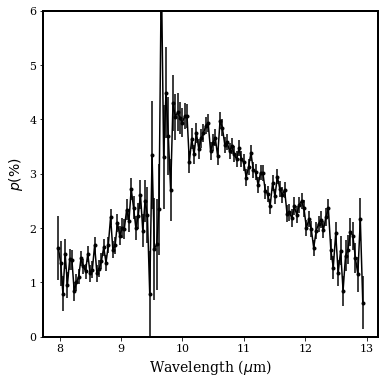

In [490]:
ax=subplot(111)
fig_size=plt.rcParams['figure.figsize']
fig_size[0]=6
fig_size[1]=6
Ip,err_p,theta,err_t=p_theta(U/I,Q/I,err_U/I,err_Q/I)
#Ip=np.sqrt((U)**2+(Q)**2)/I
#err_p=np.sqrt((U*err_U)**2+(Q*err_Q)**2)/((Ip)*I)/I
plot_pol_data(wavet,Ip*100,err_p*100,'Wavelength ($\mu$m)','$p(\%)$')
plt.ylim(0,6)
plt.setp(ax.spines.values(),linewidth=2.0)
plt.savefig('output/Elias29_p.pdf')
plt.show()

# Model Fitting (Bayesian Approach)
model: 
q = A*fa + B*fe
u = C*fa + D*fe
Four parameters to be fitted A, B, C, D. fa and fe values are known from theoretical studies. 


In [485]:
l_bn,fa_bn=readcol("BN_fa.dat",twod=False)
l_bn,fe_bn=readcol("BN_fe.dat",twod=False)

res_fit = np.polyfit(l_bn, fa_bn, 10)
fa=np.polyval(res_fit,wavet)
res_fit = np.polyfit(l_bn, fe_bn, 10)
fe=np.polyval(res_fit,wavet)

Removing 1 rows that don't match most common length 2.                       
25 rows read into array.


In [440]:
with pm.Model() as ak_model:
    #Variables are Uniform functions with width equal to 5 x std(q,u)
    A  = pm.Uniform('A',lower=min(Q/I),upper=max(Q/I))
    B  = pm.Uniform('B',lower=min(Q/I),upper=max(Q/I))
    C  = pm.Uniform('C',lower=min(U/I),upper=max(U/I))
    D  = pm.Uniform('D',lower=min(U/I),upper=max(U/I))
    #Deterministic model. Dependence of variables
    qa = A*fa
    qe = B*fe
    ua = C*fa
    ue = D*fe
    q_fit = qa + qe
    u_fit = ua + ue
    # Data likelihood. Normal distributions per each observable (data point per wavelength) 
    #with stdv the error of each data point from the observations.
    q_like  = pm.Normal('q', mu=q_fit, sd=err_U/I, observed=Q/I) 
    u_like  = pm.Normal('u', mu=u_fit, sd=err_Q/I, observed=U/I)  

with ak_model:    
    #Inference
    start = pm.find_MAP()
    step = pm.NUTS([A,B,C,D],scaling=start)
    # draw n_post posterior samples using NUTS sampling
    n_post = 2500
    trace = pm.sample(n_post, step, start=start) 

Optimization terminated successfully.
         Current function value: -1123.270946
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25


100%|██████████| 3000/3000 [00:12<00:00, 245.42it/s]


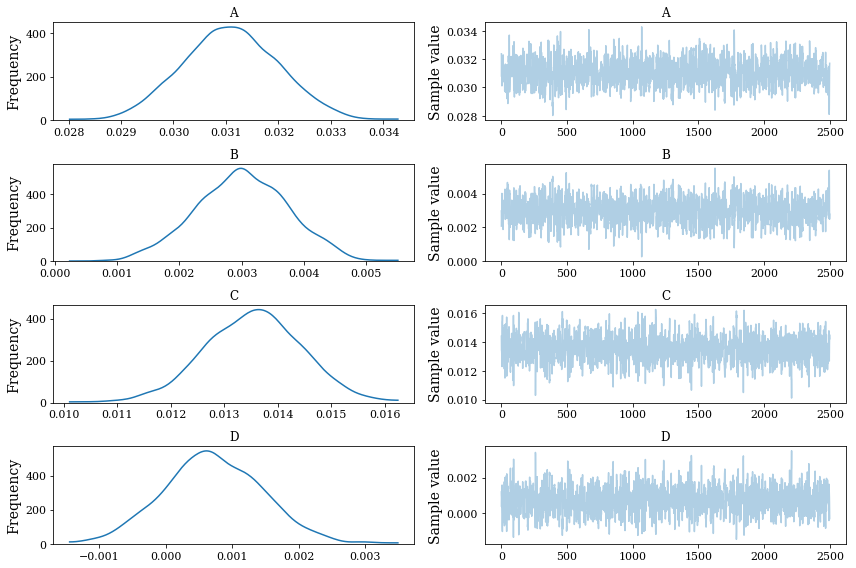

<MultiTrace: 1 chains, 2500 iterations, 8 variables>

In [464]:
_ = pm.traceplot(trace)
plt.show()
trace

In [465]:
df_trace = trace_to_dataframe(trace[n_steps:])
################
### Best fit ###
################
A_m     = scipy.stats.mode(df_trace.A)[0]
B_m     = scipy.stats.mode(df_trace.B)[0]
C_m     = scipy.stats.mode(df_trace.C)[0]
D_m     = scipy.stats.mode(df_trace.D)[0]
print A_m, B_m, C_m, D_m

A_m = trace[n_steps:].get_values('A').mean()
B_m = trace[n_steps:].get_values('B').mean()
C_m = trace[n_steps:].get_values('C').mean()
D_m = trace[n_steps:].get_values('D').mean()
print A_m, B_m, C_m, D_m

[ 0.03046673] [ 0.00299663] [ 0.0123184] [ 0.0019472]
0.0310997068828 0.00298017973106 0.0135322775738 0.000726167082578


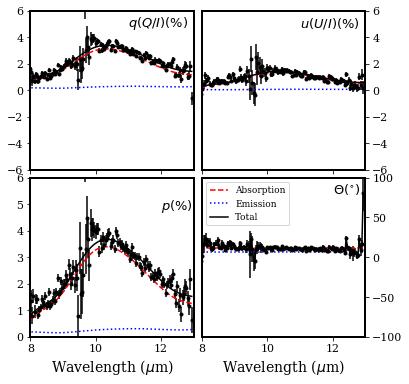

In [562]:
import plot_pol
reload(plot_pol)
from plot_pol import *
qa_bestfit = A_m*fa
qe_bestfit = B_m*fe
q_bestfit = qa_bestfit + qe_bestfit

ua_bestfit = C_m*fa
ue_bestfit = D_m*fe
u_bestfit = ua_bestfit + ue_bestfit

pa,pe,thetaa,thetae=plot_pol_decom(Q/I*100,U*100.0/I,err_Q*100.0/I,err_U*100.0/I \
                                   ,qa_bestfit*100.0,qe_bestfit*100.0,ua_bestfit*100.0,ue_bestfit*100.0,wavet,6)


#help(Uniform)

In [561]:
print  'Absorptive Component', max(pa)
print  'Emissive Component', max(pe)

Absorptive Component 3.39694994606
Emissive Component 0.306145007276
